## Install library dan import library yang dibutuhkan. Mount ke google drive untuk akses data


In [ ]:
# Install Biopython, Matplotlib, and Pandas
!pip install biopython
!pip install matplotlib
!pip install pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from Bio import SeqIO  # Import SeqIO to handle FASTA input/output
from Bio.Seq import Seq  # Import Seq to create DNA sequences
from Bio.SeqRecord import SeqRecord  # Import SeqRecord for FASTA record creation
from Bio.SeqIO import write  # Import write to output the FASTA file
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd


## Definisi model
1. Model 1 adalah model vaksin subunit protein dengan konfigurasi LFn - linker - PA (tanpa mutagenesis)
2. Model 2 adalah model vaksin subunit protein dengan konfigurasi konfigurasi LFn - linker - PA (mutagenesis)
3. Model 3 adalah model vaksin multiepitope dengan konfigurasi Adjuvant - Linker - PAMHC1 - Linker - LFnMHC1 - Linker - PAMHC2 - Linker - LFnMHC2
4. Model 4 adalah model vaksin multiepitope dengan konfigurasi Adjuvant - Linker - PAMHC2 - Linker - LFnMHC2 - Linker - PAMHC1 - Linker - LFnMHC1

## Definisikan tabel kodon standar

In [ ]:
# Tabel kodon untuk asam amino
codon_table = {
    'F': ['TTT', 'TTC'],
    'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
    'I': ['ATT', 'ATC', 'ATA'],
    'M': ['ATG'],
    'V': ['GTT', 'GTC', 'GTA', 'GTG'],
    'S': ['TCT', 'TCC', 'TCA', 'TCG'],
    'P': ['CCT', 'CCC', 'CCA', 'CCG'],
    'T': ['ACT', 'ACC', 'ACA', 'ACG'],
    'A': ['GCT', 'GCC', 'GCA', 'GCG'],
    'Y': ['TAT', 'TAC'],
    'H': ['CAT', 'CAC'],
    'Q': ['CAA', 'CAG'],
    'N': ['AAT', 'AAC'],
    'K': ['AAA', 'AAG'],
    'D': ['GAT', 'GAC'],
    'E': ['GAA', 'GAG'],
    'C': ['TGT', 'TGC'],
    'W': ['TGG'],
    'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
    'G': ['GGT', 'GGC', 'GGA', 'GGG'],
    'STOP': ['TAA', 'TAG', 'TGA']
}

# Tabel kodon untuk reverse translation (standar untuk organisme prokariotik dan eukariotik)
codon_table_reverse = {
    'A': 'GCT', 'C': 'TGT', 'D': 'GAT', 'E': 'GAA', 'F': 'TTT', 'G': 'GGT',
    'H': 'CAT', 'I': 'ATT', 'K': 'AAA', 'L': 'TTA', 'M': 'ATG', 'N': 'AAT',
    'P': 'CCT', 'Q': 'CAA', 'R': 'CGT', 'S': 'TCT', 'T': 'ACT', 'V': 'GTT',
    'W': 'TGG', 'Y': 'TAT', '*': 'TAA'  # '*' represents stop codon
}


## Terjemahkan ulang asam amino ke nukleotida untuk optimisasi sekuens

### Definisikan setiap file input dan output yang diperlukan

In [ ]:
fasta1 = "/content/drive/My Drive/Gamanthrax/Seqfix/LFn_linker_PA(tanpa_mutagenesis).fasta"
fasta2 = "/content/drive/My Drive/Gamanthrax/Seqfix/LFn_linker_PA(mutagenesis).fasta"
fasta3 = "/content/drive/My Drive/Gamanthrax/Seqfix/Adjuvant_Linker_PAMHC1_Linker_LFnMHC1_Linker_PAMHC2_Linker_LFnMHC2.fasta"
fasta4 = "/content/drive/My Drive/Gamanthrax/Seqfix/Adjuvant_Linker_PAMHC2_Linker_LFnMHC2_Linker_PAMHC1_Linker_LFnMHC1.fasta"

In [ ]:
outputfasta1 = "/content/drive/My Drive/Gamanthrax/Seqfix/Optimizedseq/LFn_linker_PA(tanpa_mutagenesis).fasta"
outputfasta2 = "/content/drive/My Drive/Gamanthrax/Seqfix/Optimizedseq/LFn_linker_PA(mutagenesis).fasta"
outputfasta3 = "/content/drive/My Drive/Gamanthrax/Seqfix/Optimizedseq/Adjuvant_Linker_PAMHC1_Linker_LFnMHC1_Linker_PAMHC2_Linker_LFnMHC2.fasta"
outputfasta4 = "/content/drive/My Drive/Gamanthrax/Seqfix/Optimizedseq/Adjuvant_Linker_PAMHC2_Linker_LFnMHC2_Linker_PAMHC1_Linker_LFnMHC1.fasta"

### Fungsi untuk reverse translate dari asam amino ke nukleotida tanpa optimalisasi

In [ ]:
# Fungsi untuk melakukan reverse translation dari peptida ke DNA
def reverse_translate(peptide_sequence):
    dna_sequence = []
    for aa in peptide_sequence:
        if aa in codon_table:
            dna_sequence.append(codon_table_reverse[aa])
        else:
            raise ValueError(f"Amino acid '{aa}' not recognized in codon table.")
    return ''.join(dna_sequence)

# Fungsi untuk membaca file FASTA yang berisi peptida, reverse translate, dan menulis ke file FASTA output
def reverse_translate_fasta_to_dna(fasta_input, fasta_output):
    sequences = []

    # Membaca file FASTA input
    for record in SeqIO.parse(fasta_input, "fasta"):
        peptide_sequence = str(record.seq)
        dna_sequence = reverse_translate(peptide_sequence)

        # Membuat SeqRecord baru dengan DNA sequence
        dna_record = SeqRecord(Seq(dna_sequence), id=record.id, description="Reverse translated to DNA")
        sequences.append(dna_record)

    # Menulis file FASTA dengan DNA sequence
    with open(fasta_output, 'w') as output_handle:
        SeqIO.write(sequences, output_handle, "fasta")

    print(f"Reverse translated sequences saved to {fasta_output}.")


In [ ]:
reverse_translate_fasta_to_dna(fasta1, outputfasta1)

Reverse translated sequences saved to /content/drive/My Drive/Gamanthrax/Seqfix/Optimizedseq/LFn_linker_PA(tanpa_mutagenesis).fasta.


In [ ]:
reverse_translate_fasta_to_dna(fasta2, outputfasta2)

Reverse translated sequences saved to /content/drive/My Drive/Gamanthrax/Seqfix/Optimizedseq/LFn_linker_PA(mutagenesis).fasta.


In [ ]:
reverse_translate_fasta_to_dna(fasta3, outputfasta3)

Reverse translated sequences saved to /content/drive/My Drive/Gamanthrax/Seqfix/Optimizedseq/Adjuvant_Linker_PAMHC1_Linker_LFnMHC1_Linker_PAMHC2_Linker_LFnMHC2.fasta.


In [ ]:
reverse_translate_fasta_to_dna(fasta4, outputfasta4)

Reverse translated sequences saved to /content/drive/My Drive/Gamanthrax/Seqfix/Optimizedseq/Adjuvant_Linker_PAMHC2_Linker_LFnMHC2_Linker_PAMHC1_Linker_LFnMHC1.fasta.


## Optimalisasi codon

### Definisikan variabel codon usage dari *Brassica juncea*
Codon usage diambil dari https://www.kazusa.or.jp/codon/cgi-bin/showcodon.cgi?species=3707

In [ ]:
# Data penggunaan kodon
codon_usage = {
    # Tambahkan data penggunaan kodon di sini
    'TTT': 0.0175, 'TTC': 0.0268,
    'TTA': 0.0081, 'TTG': 0.0181,
    'CTT': 0.0225, 'CTC': 0.0233, 'CTA': 0.0079, 'CTG': 0.0099,
    'ATT': 0.0168, 'ATC': 0.0243, 'ATA': 0.0096,
    'ATG': 0.0249,
    'GTT': 0.0245, 'GTC': 0.0185, 'GTA': 0.0060, 'GTG': 0.0193,
    'TCT': 0.0189, 'TCC': 0.0144, 'TCA': 0.0124, 'TCG': 0.0072,
    'CCT': 0.0179, 'CCC': 0.0079, 'CCA': 0.0138, 'CCG': 0.0096,
    'ACT': 0.0171, 'ACC': 0.0171, 'ACA': 0.0112, 'ACG': 0.0099,
    'GCT': 0.0327, 'GCC': 0.0162, 'GCA': 0.0148, 'GCG': 0.0102,
    'TAT': 0.0114, 'TAC': 0.0198,
    'CAT': 0.0129, 'CAC': 0.0133,
    'CAA': 0.0148, 'CAG': 0.0157,
    'AAT': 0.0132, 'AAC': 0.0275,
    'AAA': 0.0235, 'AAG': 0.0370,
    'GAT': 0.0280, 'GAC': 0.0268,
    'GAA': 0.0265, 'GAG': 0.0400,
    'TGT': 0.0082, 'TGC': 0.0102,
    'TGG': 0.0123,
    'CGT': 0.0101, 'CGC': 0.0055, 'CGA': 0.0035, 'CGG': 0.0044,
    'AGA': 0.0146, 'AGG': 0.0122,
    'GGT': 0.0241, 'GGC': 0.0126, 'GGA': 0.0245, 'GGG': 0.0121,
    'TAA': 0.0013, 'TAG': 0.0003, 'TGA': 0.0013
}

### Definisikan output untuk setiap sequence yang dioptimisasi

In [ ]:
Optimizefix1 = "/content/drive/My Drive/Gamanthrax/Seqfix/Optimizedseq/Fix/LFn_linker_PA(tanpa_mutagenesis)fix.fasta"
Optimizefix2 = "/content/drive/My Drive/Gamanthrax/Seqfix/Optimizedseq/Fix/LFn_linker_PA(mutagenesis)fix.fasta"
Optimizefix3 = "/content/drive/My Drive/Gamanthrax/Seqfix/Optimizedseq/Fix/Adjuvant_Linker_PAMHC1_Linker_LFnMHC1_Linker_PAMHC2_Linker_LFnMHC2fix.fasta"
Optimizefix4 = "/content/drive/My Drive/Gamanthrax/Seqfix/Optimizedseq/Fix/Adjuvant_Linker_PAMHC2_Linker_LFnMHC2_Linker_PAMHC1_Linker_LFnMHC1fix.fasta"

### Optimisasi codon untuk setiap model vaksin

In [ ]:
from Bio import SeqIO

# Fungsi untuk memilih kodon optimal berdasarkan penggunaan tertinggi dalam codon_usage
def get_optimal_codon(codon_table, codon_usage, codon):
    # Cari asam amino yang sesuai untuk kodon yang diberikan
    for amino_acid, codons in codon_table.items():
        if codon in codons:
            # Pilih kodon dengan frekuensi tertinggi dalam codon_usage
            return max(codons, key=lambda c: codon_usage.get(c, 0))
    return codon  # Jika tidak ditemukan, kembalikan kodon asli

# Fungsi untuk optimasi sequence DNA
def optimize_sequence(sequence, codon_table, codon_usage):
    optimized_seq = ""

    # Iterasi setiap kodon dalam sequence DNA
    for i in range(0, len(sequence), 3):
        codon = sequence[i:i+3]

        # Optimasi kodon
        optimized_codon = get_optimal_codon(codon_table, codon_usage, codon)
        optimized_seq += optimized_codon

    return optimized_seq

# Daftar file input dan output
input_files = [outputfasta1, outputfasta2, outputfasta3, outputfasta4]
output_files = [Optimizefix1, Optimizefix2, Optimizefix3, Optimizefix4]

# Loop untuk melakukan optimasi pada setiap file input dan menyimpan hasil ke file output yang sesuai
for input_file, output_file in zip(input_files, output_files):
    # Membaca sequence dari file fasta
    fasta_sequence = str(next(SeqIO.parse(input_file, "fasta")).seq)

    # Optimasi sequence DNA
    optimized_sequence = optimize_sequence(fasta_sequence, codon_table, codon_usage)

    # Menyimpan hasil optimasi ke file output
    with open(output_file, "w") as f:
        f.write(">Optimized_sequence\n")
        f.write(optimized_sequence)


## Bandingkan penggunaan codon awal dan akhir

### Plot untuk perbandingan pada vaksin model 1

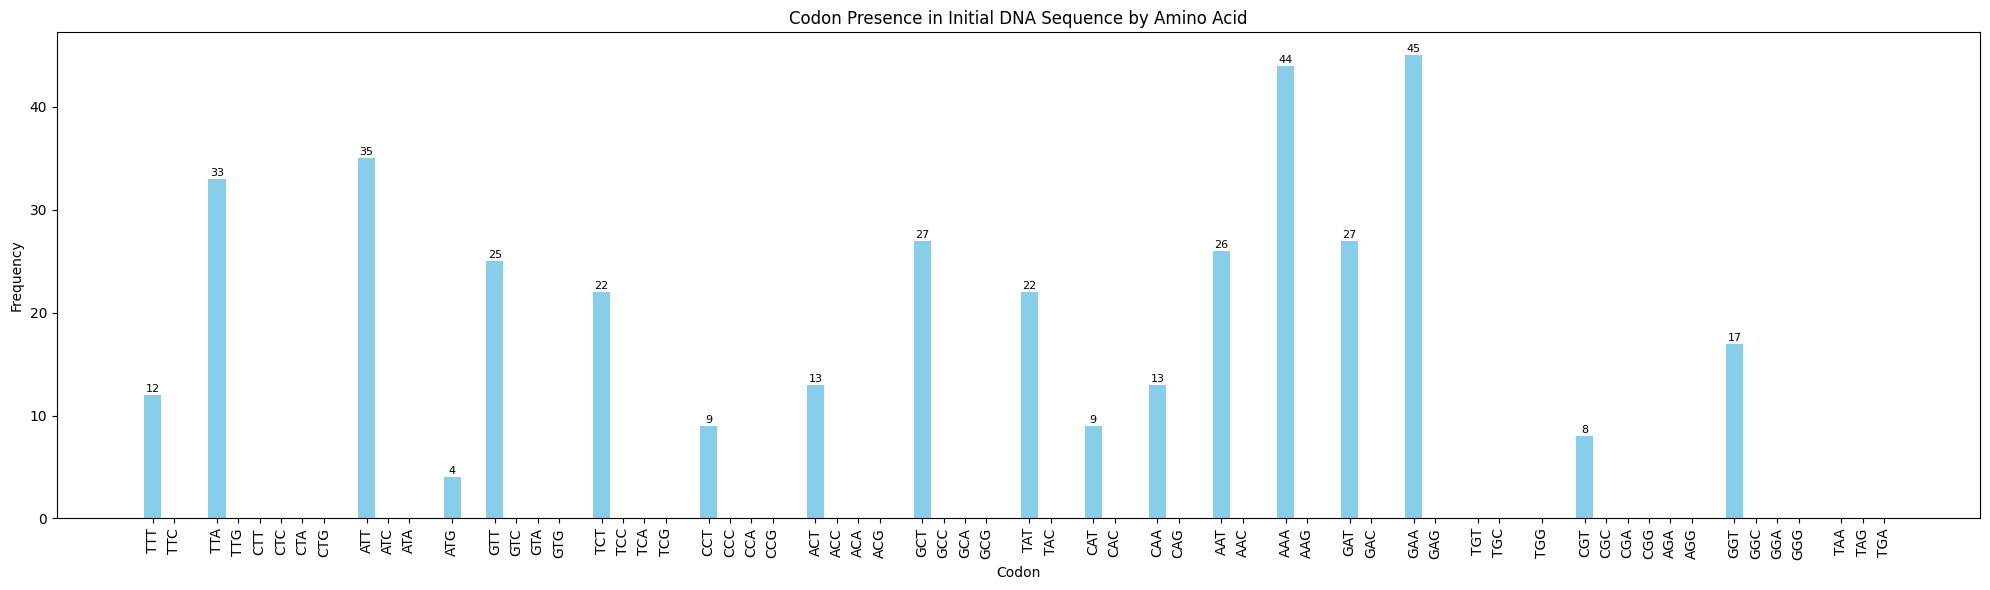

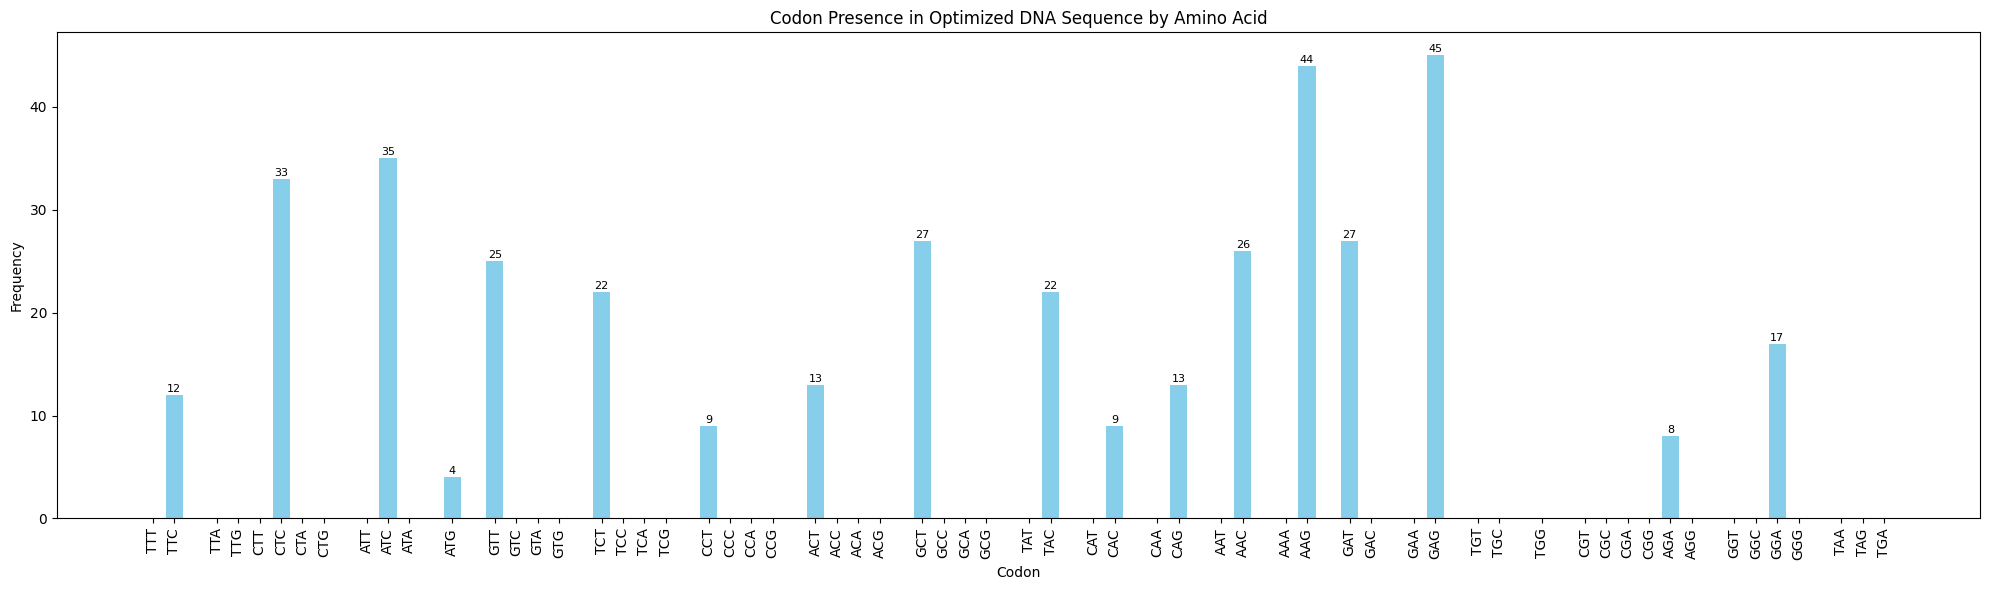

In [ ]:
# Import library yang dibutuhkan
import matplotlib.pyplot as plt
from Bio import SeqIO
import numpy as np

# Fungsi untuk menghitung frekuensi kemunculan kodon dalam sequence
def calculate_codon_frequencies(sequence, codon_table):
    codon_frequencies = {amino: {codon: 0 for codon in codons} for amino, codons in codon_table.items()}
    for i in range(0, len(sequence) - 2, 3):
        codon = sequence[i:i + 3]
        for amino, codons in codon_table.items():
            if codon in codons:
                codon_frequencies[amino][codon] += 1
    return codon_frequencies

# Fungsi untuk membuat plot frekuensi kodon
def plot_codon_frequencies(codon_frequencies, title):
    fig, ax = plt.subplots(figsize=(20, 6))
    positions = []
    labels = []
    frequencies = []

    # Menyusun data untuk plot
    position = 0
    for amino, codons in codon_frequencies.items():
        for codon, freq in codons.items():
            positions.append(position)
            labels.append(codon)
            frequencies.append(freq)
            position += 1
        position += 1  # Tambahkan jarak antar kelompok asam amino

    # Membuat plot bar untuk setiap kodon
    ax.bar(positions, frequencies, color='skyblue')
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_xlabel("Codon")
    ax.set_ylabel("Frequency")
    ax.set_title(title)

    # Menambahkan label frekuensi di atas setiap bar jika ada
    for i, freq in enumerate(frequencies):
        if freq > 0:
            ax.text(positions[i], frequencies[i] + 0.1, str(freq), ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

# Membaca sequence DNA dari file fasta_path
def read_sequence_from_file(fasta_path):
    sequence = ""
    with open(fasta_path, "r") as fasta_file:
        for record in SeqIO.parse(fasta_file, "fasta"):
            sequence = str(record.seq).upper()
    return sequence

# Path ke file input dan hasil optimasi
fasta_path_initial = outputfasta1  # Path file FASTA asli
fasta_path_optimized = Optimizefix1  # Path file FASTA hasil optimasi

# Membaca sequence awal dan hasil optimasi
sequence_initial = read_sequence_from_file(fasta_path_initial)
sequence_optimized = read_sequence_from_file(fasta_path_optimized)

# Menghitung frekuensi kodon untuk sequence awal
codon_frequencies_initial = calculate_codon_frequencies(sequence_initial, codon_table)
# Menghitung frekuensi kodon untuk sequence hasil optimasi
codon_frequencies_optimized = calculate_codon_frequencies(sequence_optimized, codon_table)

# Membuat plot untuk sequence awal
plot_codon_frequencies(codon_frequencies_initial, "Codon Presence in Initial DNA Sequence by Amino Acid")
# Membuat plot untuk sequence hasil optimasi
plot_codon_frequencies(codon_frequencies_optimized, "Codon Presence in Optimized DNA Sequence by Amino Acid")


### Plot untuk perbandingan vaksin model 2

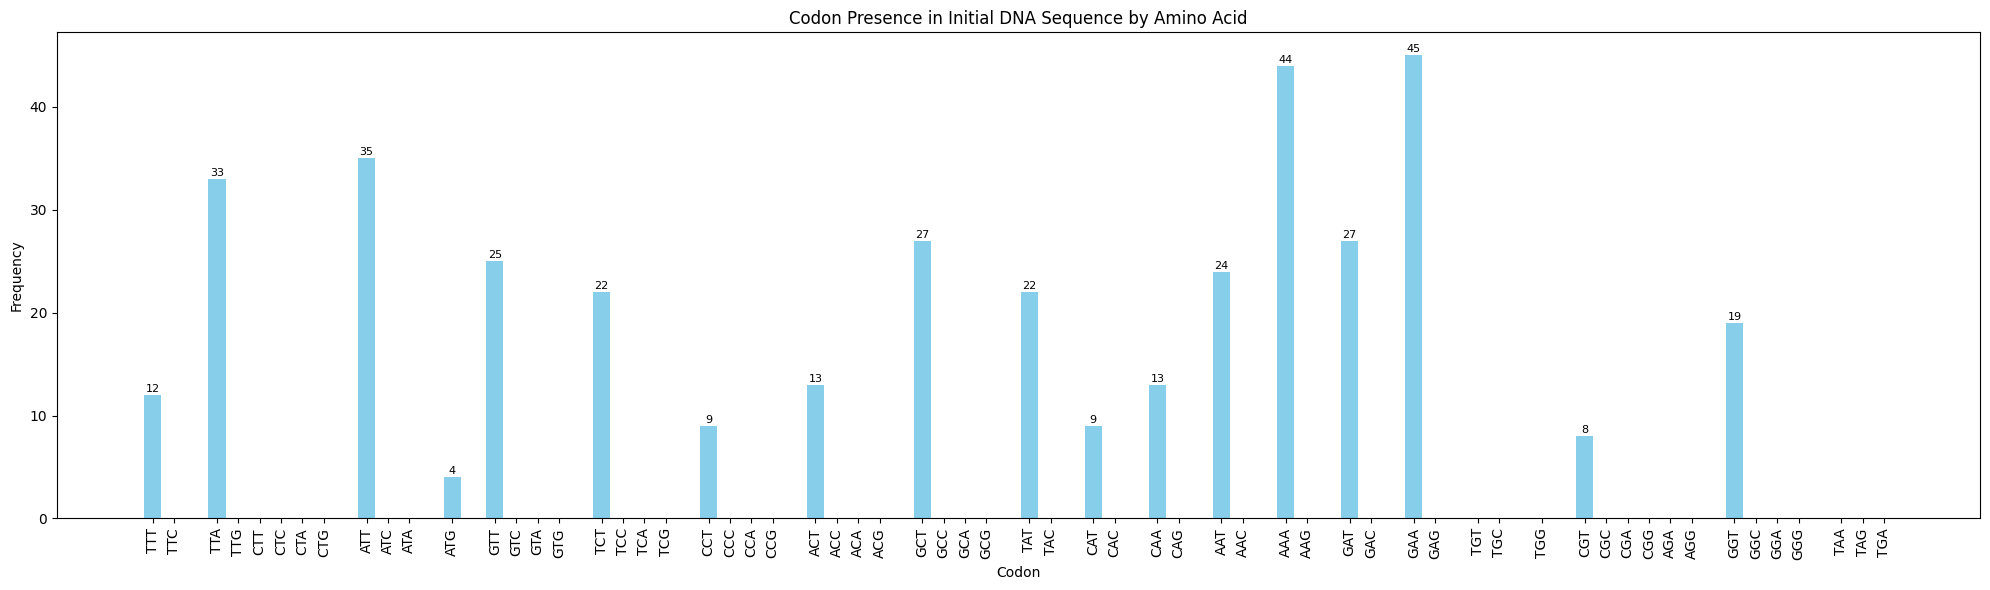

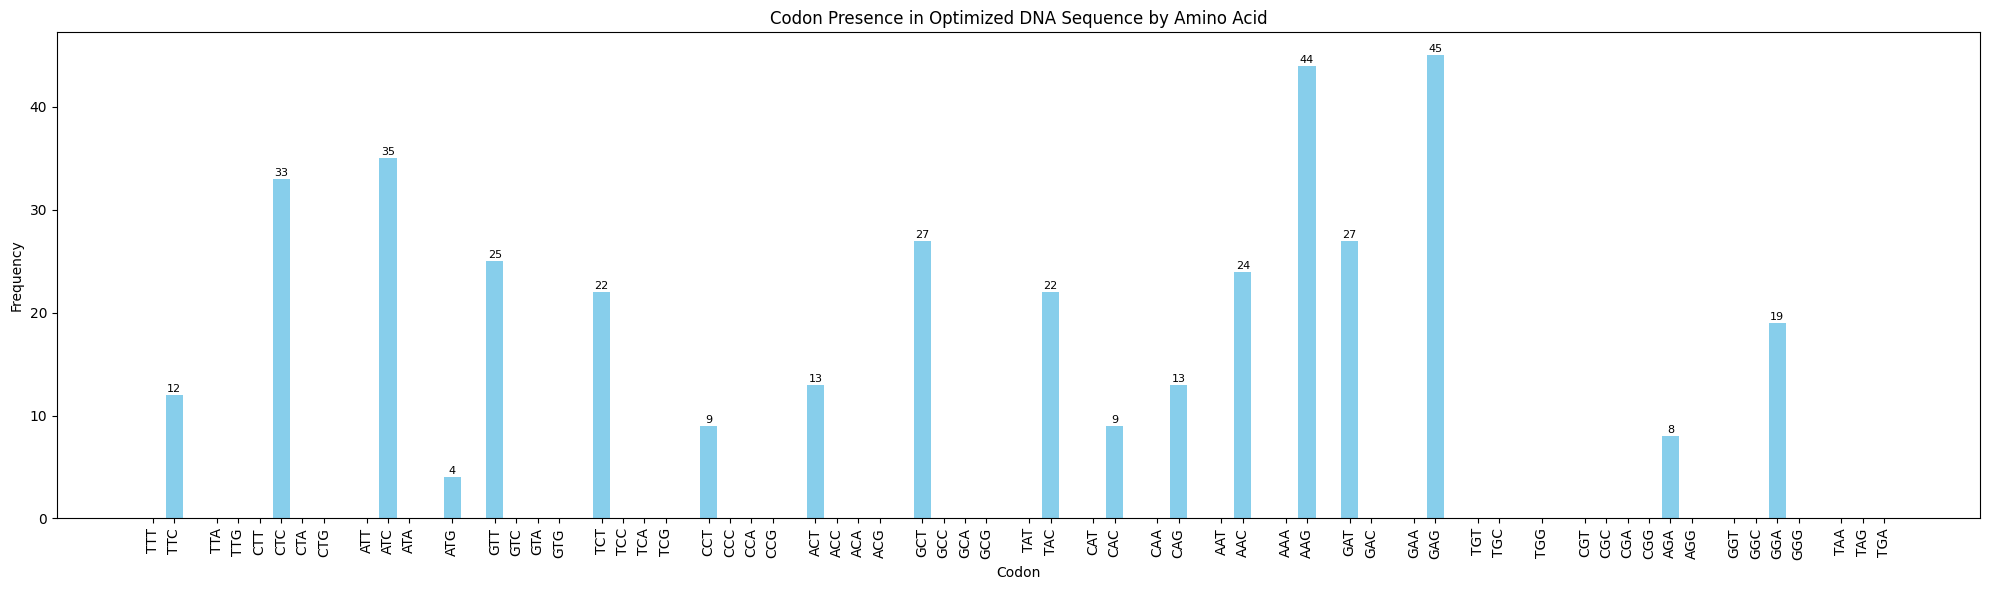

In [ ]:
# Import library yang dibutuhkan
import matplotlib.pyplot as plt
from Bio import SeqIO
import numpy as np

# Fungsi untuk menghitung frekuensi kemunculan kodon dalam sequence
def calculate_codon_frequencies(sequence, codon_table):
    codon_frequencies = {amino: {codon: 0 for codon in codons} for amino, codons in codon_table.items()}
    for i in range(0, len(sequence) - 2, 3):
        codon = sequence[i:i + 3]
        for amino, codons in codon_table.items():
            if codon in codons:
                codon_frequencies[amino][codon] += 1
    return codon_frequencies

# Fungsi untuk membuat plot frekuensi kodon
def plot_codon_frequencies(codon_frequencies, title):
    fig, ax = plt.subplots(figsize=(20, 6))
    positions = []
    labels = []
    frequencies = []

    # Menyusun data untuk plot
    position = 0
    for amino, codons in codon_frequencies.items():
        for codon, freq in codons.items():
            positions.append(position)
            labels.append(codon)
            frequencies.append(freq)
            position += 1
        position += 1  # Tambahkan jarak antar kelompok asam amino

    # Membuat plot bar untuk setiap kodon
    ax.bar(positions, frequencies, color='skyblue')
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_xlabel("Codon")
    ax.set_ylabel("Frequency")
    ax.set_title(title)

    # Menambahkan label frekuensi di atas setiap bar jika ada
    for i, freq in enumerate(frequencies):
        if freq > 0:
            ax.text(positions[i], frequencies[i] + 0.1, str(freq), ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

# Membaca sequence DNA dari file fasta_path
def read_sequence_from_file(fasta_path):
    sequence = ""
    with open(fasta_path, "r") as fasta_file:
        for record in SeqIO.parse(fasta_file, "fasta"):
            sequence = str(record.seq).upper()
    return sequence

# Path ke file input dan hasil optimasi
fasta_path_initial = outputfasta2  # Path file FASTA asli
fasta_path_optimized = Optimizefix2  # Path file FASTA hasil optimasi

# Membaca sequence awal dan hasil optimasi
sequence_initial = read_sequence_from_file(fasta_path_initial)
sequence_optimized = read_sequence_from_file(fasta_path_optimized)

# Menghitung frekuensi kodon untuk sequence awal
codon_frequencies_initial = calculate_codon_frequencies(sequence_initial, codon_table)
# Menghitung frekuensi kodon untuk sequence hasil optimasi
codon_frequencies_optimized = calculate_codon_frequencies(sequence_optimized, codon_table)

# Membuat plot untuk sequence awal
plot_codon_frequencies(codon_frequencies_initial, "Codon Presence in Initial DNA Sequence by Amino Acid")
# Membuat plot untuk sequence hasil optimasi
plot_codon_frequencies(codon_frequencies_optimized, "Codon Presence in Optimized DNA Sequence by Amino Acid")


### Plot untuk perbandingan vaksin model 3

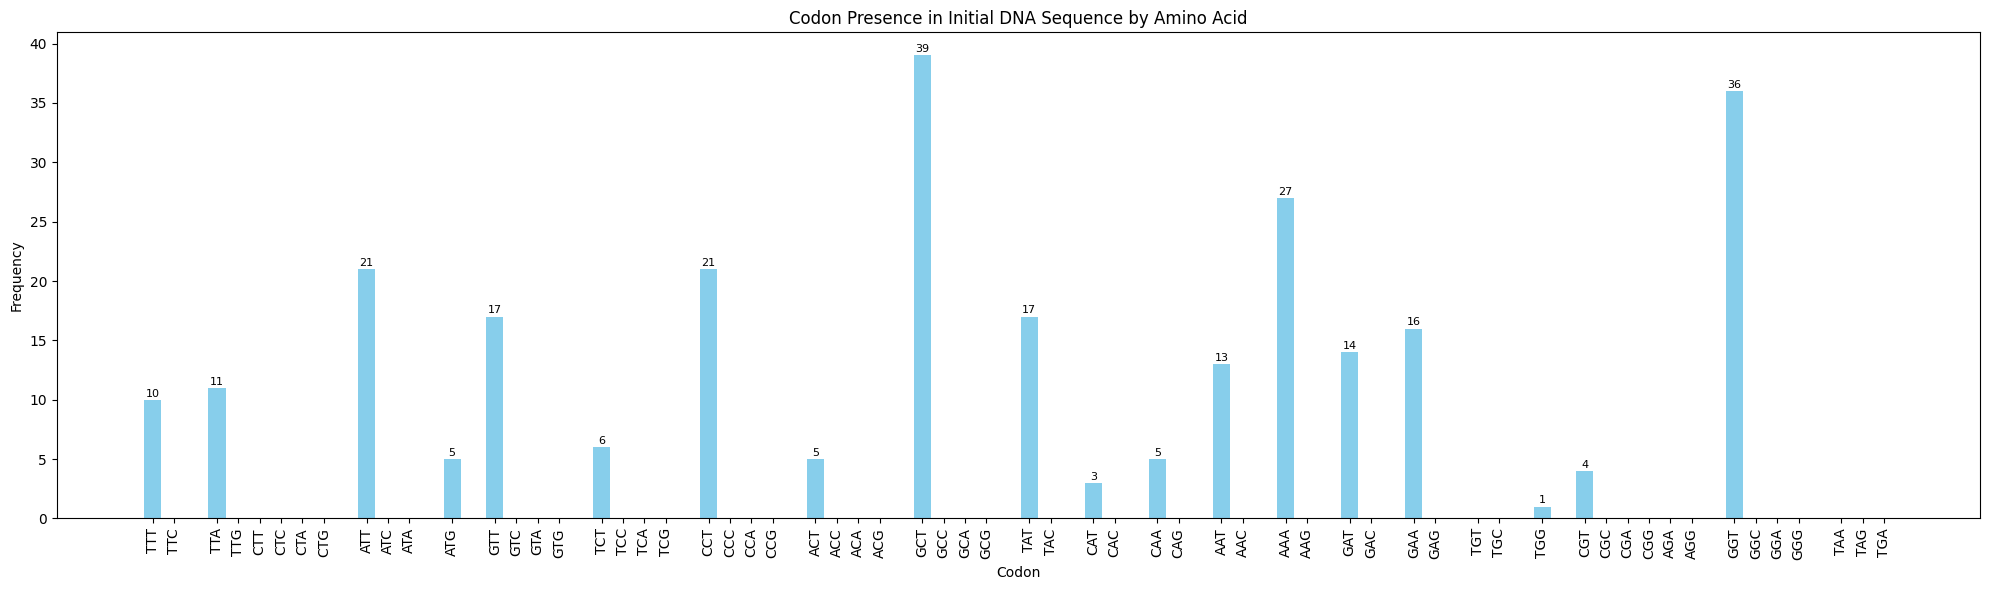

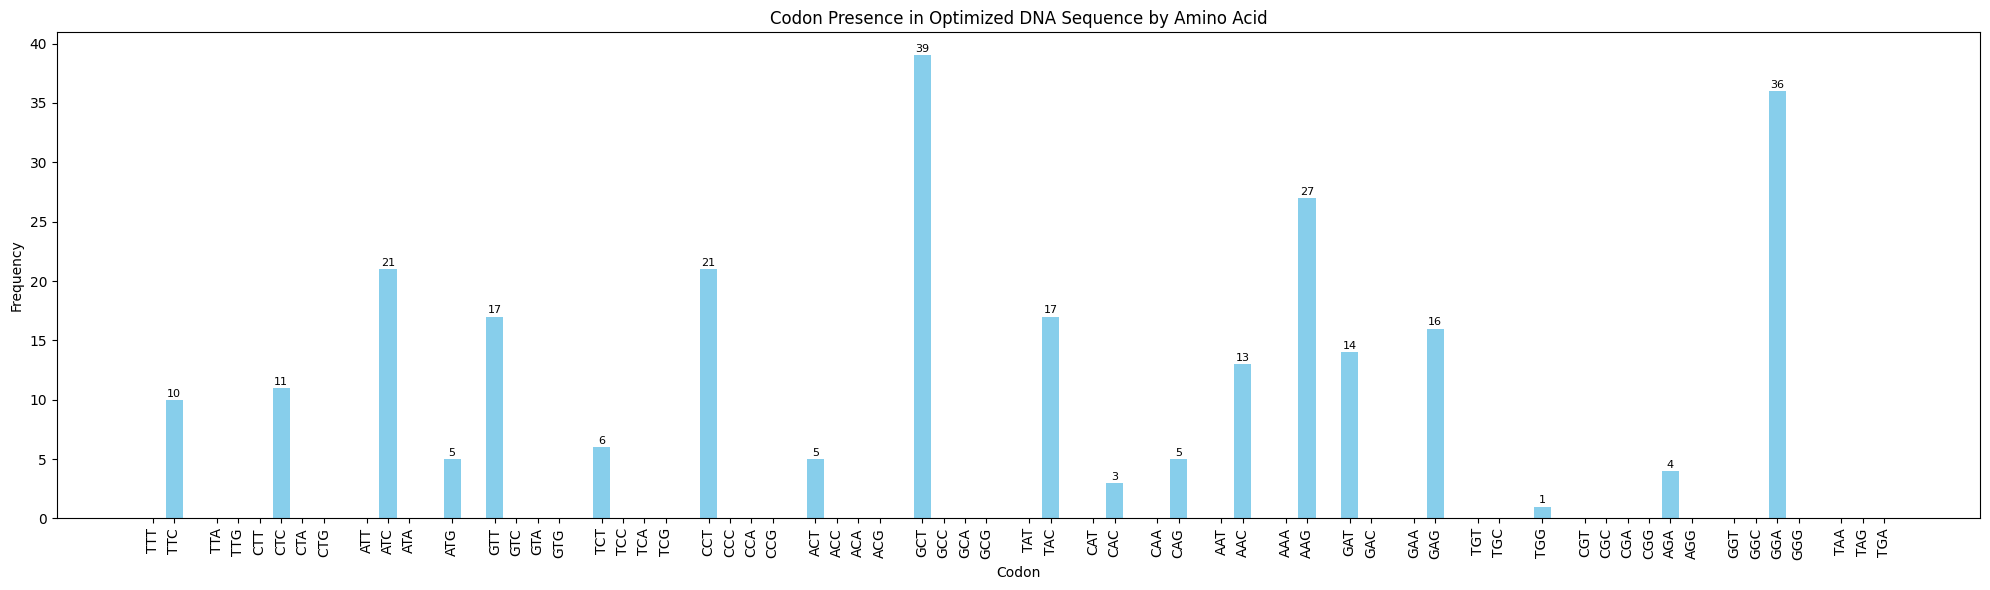

In [ ]:
# Import library yang dibutuhkan
import matplotlib.pyplot as plt
from Bio import SeqIO
import numpy as np

# Fungsi untuk menghitung frekuensi kemunculan kodon dalam sequence
def calculate_codon_frequencies(sequence, codon_table):
    codon_frequencies = {amino: {codon: 0 for codon in codons} for amino, codons in codon_table.items()}
    for i in range(0, len(sequence) - 2, 3):
        codon = sequence[i:i + 3]
        for amino, codons in codon_table.items():
            if codon in codons:
                codon_frequencies[amino][codon] += 1
    return codon_frequencies

# Fungsi untuk membuat plot frekuensi kodon
def plot_codon_frequencies(codon_frequencies, title):
    fig, ax = plt.subplots(figsize=(20, 6))
    positions = []
    labels = []
    frequencies = []

    # Menyusun data untuk plot
    position = 0
    for amino, codons in codon_frequencies.items():
        for codon, freq in codons.items():
            positions.append(position)
            labels.append(codon)
            frequencies.append(freq)
            position += 1
        position += 1  # Tambahkan jarak antar kelompok asam amino

    # Membuat plot bar untuk setiap kodon
    ax.bar(positions, frequencies, color='skyblue')
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_xlabel("Codon")
    ax.set_ylabel("Frequency")
    ax.set_title(title)

    # Menambahkan label frekuensi di atas setiap bar jika ada
    for i, freq in enumerate(frequencies):
        if freq > 0:
            ax.text(positions[i], frequencies[i] + 0.1, str(freq), ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

# Membaca sequence DNA dari file fasta_path
def read_sequence_from_file(fasta_path):
    sequence = ""
    with open(fasta_path, "r") as fasta_file:
        for record in SeqIO.parse(fasta_file, "fasta"):
            sequence = str(record.seq).upper()
    return sequence

# Path ke file input dan hasil optimasi
fasta_path_initial = outputfasta3  # Path file FASTA asli
fasta_path_optimized = Optimizefix3  # Path file FASTA hasil optimasi

# Membaca sequence awal dan hasil optimasi
sequence_initial = read_sequence_from_file(fasta_path_initial)
sequence_optimized = read_sequence_from_file(fasta_path_optimized)

# Menghitung frekuensi kodon untuk sequence awal
codon_frequencies_initial = calculate_codon_frequencies(sequence_initial, codon_table)
# Menghitung frekuensi kodon untuk sequence hasil optimasi
codon_frequencies_optimized = calculate_codon_frequencies(sequence_optimized, codon_table)

# Membuat plot untuk sequence awal
plot_codon_frequencies(codon_frequencies_initial, "Codon Presence in Initial DNA Sequence by Amino Acid")
# Membuat plot untuk sequence hasil optimasi
plot_codon_frequencies(codon_frequencies_optimized, "Codon Presence in Optimized DNA Sequence by Amino Acid")


### Plot untuk perbandingan vaksin model 4

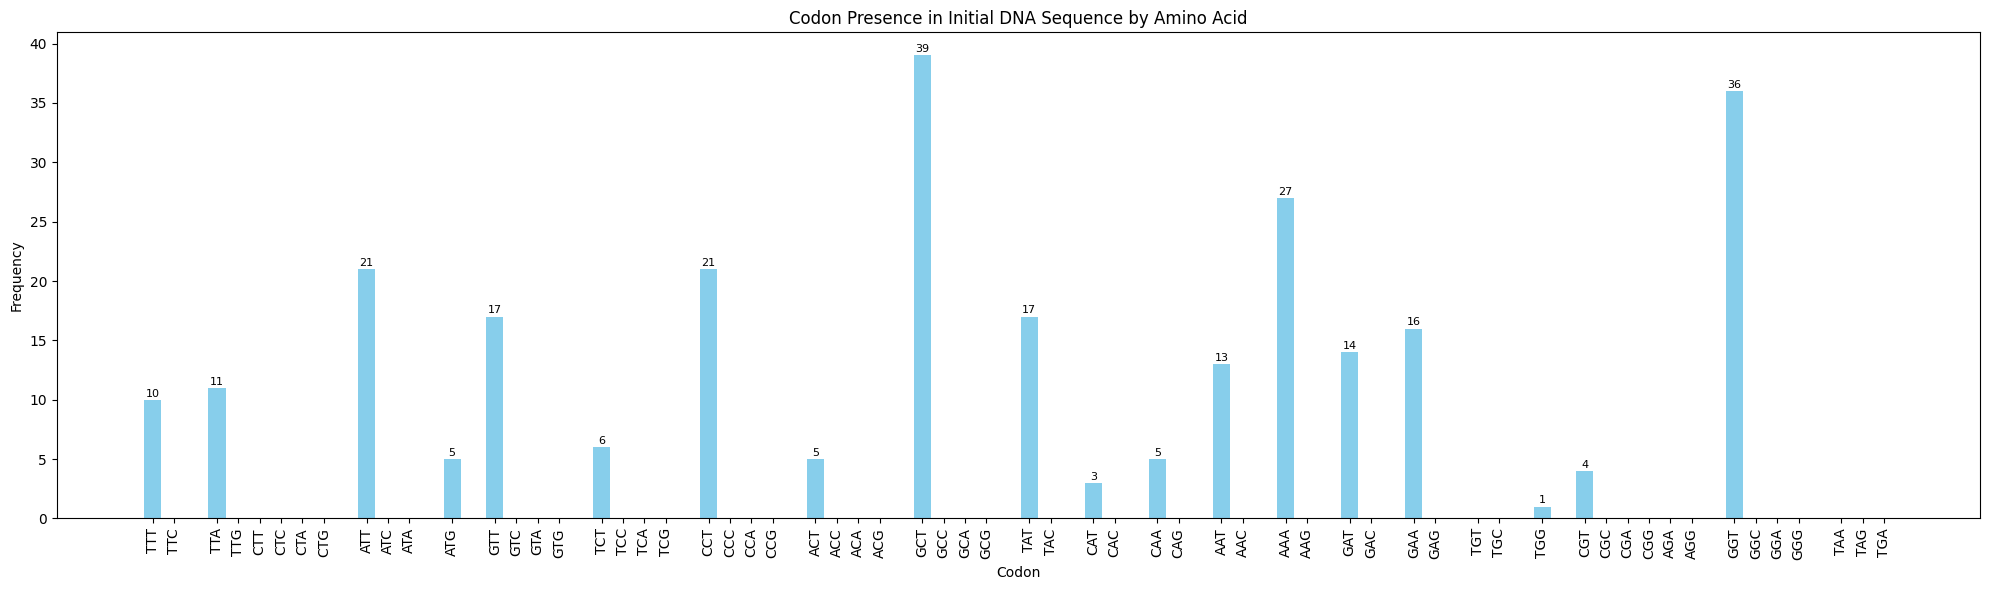

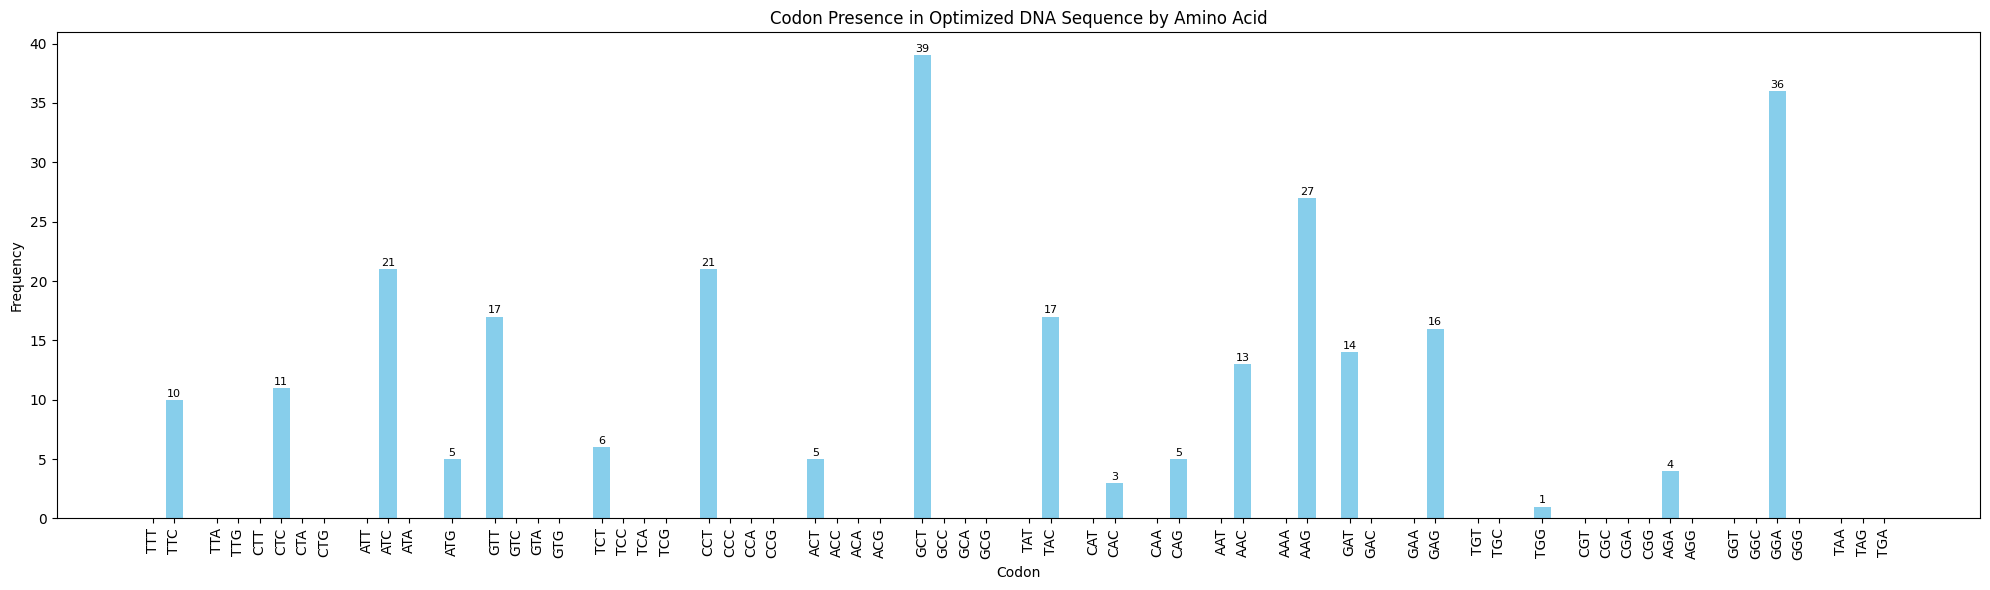

In [ ]:
# Import library yang dibutuhkan
import matplotlib.pyplot as plt
from Bio import SeqIO
import numpy as np

# Fungsi untuk menghitung frekuensi kemunculan kodon dalam sequence
def calculate_codon_frequencies(sequence, codon_table):
    codon_frequencies = {amino: {codon: 0 for codon in codons} for amino, codons in codon_table.items()}
    for i in range(0, len(sequence) - 2, 3):
        codon = sequence[i:i + 3]
        for amino, codons in codon_table.items():
            if codon in codons:
                codon_frequencies[amino][codon] += 1
    return codon_frequencies

# Fungsi untuk membuat plot frekuensi kodon
def plot_codon_frequencies(codon_frequencies, title):
    fig, ax = plt.subplots(figsize=(20, 6))
    positions = []
    labels = []
    frequencies = []

    # Menyusun data untuk plot
    position = 0
    for amino, codons in codon_frequencies.items():
        for codon, freq in codons.items():
            positions.append(position)
            labels.append(codon)
            frequencies.append(freq)
            position += 1
        position += 1  # Tambahkan jarak antar kelompok asam amino

    # Membuat plot bar untuk setiap kodon
    ax.bar(positions, frequencies, color='skyblue')
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_xlabel("Codon")
    ax.set_ylabel("Frequency")
    ax.set_title(title)

    # Menambahkan label frekuensi di atas setiap bar jika ada
    for i, freq in enumerate(frequencies):
        if freq > 0:
            ax.text(positions[i], frequencies[i] + 0.1, str(freq), ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

# Membaca sequence DNA dari file fasta_path
def read_sequence_from_file(fasta_path):
    sequence = ""
    with open(fasta_path, "r") as fasta_file:
        for record in SeqIO.parse(fasta_file, "fasta"):
            sequence = str(record.seq).upper()
    return sequence

# Path ke file input dan hasil optimasi
fasta_path_initial = outputfasta3  # Path file FASTA asli
fasta_path_optimized = Optimizefix3  # Path file FASTA hasil optimasi

# Membaca sequence awal dan hasil optimasi
sequence_initial = read_sequence_from_file(fasta_path_initial)
sequence_optimized = read_sequence_from_file(fasta_path_optimized)

# Menghitung frekuensi kodon untuk sequence awal
codon_frequencies_initial = calculate_codon_frequencies(sequence_initial, codon_table)
# Menghitung frekuensi kodon untuk sequence hasil optimasi
codon_frequencies_optimized = calculate_codon_frequencies(sequence_optimized, codon_table)

# Membuat plot untuk sequence awal
plot_codon_frequencies(codon_frequencies_initial, "Codon Presence in Initial DNA Sequence by Amino Acid")
# Membuat plot untuk sequence hasil optimasi
plot_codon_frequencies(codon_frequencies_optimized, "Codon Presence in Optimized DNA Sequence by Amino Acid")


## Hitung RSCU (Relative synonymous codon usage) dan CAI (Codon Adaptation Index)

### Hitung RSCU dan Relative adaptiveness
Persamaan untuk perhitungan diambil dari https://pmc.ncbi.nlm.nih.gov/articles/PMC340524/?page=5#supplementary-material1, kami sudah merangkum persamaan yang digunakan dan dapat diakses pada https://drive.google.com/file/d/1JYer5qicWL2qC29VpM3gBPudWft6wty1/view?usp=drive_link


In [ ]:
# Calculate RSCU values and Relative Adaptiveness
rscu_values = {}
relative_adaptiveness = {}
rscu_max_values = {}

for aa, codons in codon_table.items():
    total_usage = sum([codon_usage.get(codon, 0) for codon in codons])
    if total_usage == 0:
        continue
    for codon in codons:
        usage = codon_usage.get(codon, 0)
        # RSCU calculation
        rscu_values[codon] = usage / (total_usage / len(codons))
        # Relative adaptiveness calculation
        max_usage = max([codon_usage.get(c, 0) for c in codons])
        relative_adaptiveness[codon] = rscu_values[codon] / (max_usage / (total_usage / len(codons)))

    # Calculate RSCU_max for each codon in the amino acid
    rscu_max = max([rscu_values[codon] for codon in codons if codon in rscu_values])
    for codon in codons:
        rscu_max_values[codon] = rscu_max

# Create a DataFrame for the output
df = pd.DataFrame({
    'Codon': rscu_values.keys(),
    'RSCU': rscu_values.values(),
    'Relative Adaptiveness': relative_adaptiveness.values(),
    'RSCU_max': [rscu_max_values[codon] for codon in rscu_values.keys()]
})

# Sort by Codon
df = df.sort_values(by='Codon').reset_index(drop=True)

# Display the resulting DataFrame
print(df)


   Codon      RSCU  Relative Adaptiveness  RSCU_max
0    AAA  0.776860               0.635135  1.223140
1    AAC  1.351351               1.000000  1.351351
2    AAG  1.223140               1.000000  1.223140
3    AAT  0.648649               0.480000  1.351351
4    ACA  0.810127               0.654971  1.236890
..   ...       ...                    ...       ...
57   TGT  0.891304               0.803922  1.108696
58   TTA  0.541203               0.347639  1.556793
59   TTC  1.209932               1.000000  1.209932
60   TTG  1.209354               0.776824  1.556793
61   TTT  0.790068               0.652985  1.209932

[62 rows x 4 columns]


### Simpan tabel hasil ke CSV

In [ ]:
Outputdf = "/content/drive/My Drive/Gamanthrax/Seqoptimization/rscu_values.csv"


In [ ]:
# Menyimpan DataFrame ke file CSV
df.to_csv(Outputdf, index=False)

print(f"Tabel RSCU dan Relative Adaptiveness disimpan di {Outputdf}.")


Tabel RSCU dan Relative Adaptiveness disimpan di /content/drive/My Drive/Gamanthrax/Seqoptimization/rscu_values.csv.


### Rubah sequence yang telah dioptimisasi sebelumnya ke format list untuk perhtitungan CAI

#### List codon untuk sequence setelah optimisasi

In [ ]:
CodonOptimized1 = "/content/drive/My Drive/Gamanthrax/Seqoptimization/CodonOptimized1.csv"
CodonOptimized2 = "/content/drive/My Drive/Gamanthrax/Seqoptimization/CodonOptimized2.csv"
CodonOptimized3 = "/content/drive/My Drive/Gamanthrax/Seqoptimization/CodonOptimized3.csv"
CodonOptimized4 = "/content/drive/My Drive/Gamanthrax/Seqoptimization/CodonOptimized4.csv"

In [ ]:
CodonInitial1 = "/content/drive/My Drive/Gamanthrax/Seqoptimization/CodonInitial1.csv"
CodonInitial2 = "/content/drive/My Drive/Gamanthrax/Seqoptimization/CodonInitial2.csv"
CodonInitial3 = "/content/drive/My Drive/Gamanthrax/Seqoptimization/CodonInitial3.csv"
CodonInitial4 = "/content/drive/My Drive/Gamanthrax/Seqoptimization/CodonInitial4.csv"

In [ ]:
from Bio import SeqIO
import pandas as pd

# Fungsi untuk membagi sekuens menjadi codon
def get_codons(sequence):
    return [sequence[i:i+3] for i in range(0, len(sequence), 3)]

# Daftar file input FASTA dan variabel untuk output
fasta_files = [Optimizefix1, Optimizefix2, Optimizefix3, Optimizefix4]
output_vars = ["CodonOptimized1", "CodonOptimized2", "CodonOptimized3", "CodonOptimized4"]

# Dictionary untuk menyimpan setiap DataFrame hasil dengan nama yang diinginkan
optimized_codon_dfs = {}

# Loop untuk membaca tiap file FASTA dan menyimpan ke variabel yang sesuai
for i, (fasta_file, output_var) in enumerate(zip(fasta_files, output_vars), 1):
    codon_list = []

    for record in SeqIO.parse(fasta_file, "fasta"):
        # Mengambil sekuens sebagai string
        seq = str(record.seq)
        # Mendapatkan list codon dari sekuens
        codons = get_codons(seq)
        codon_list.extend(codons)

    # Membuat DataFrame dan menyimpan di dictionary dengan nama variabel output
    codon_df = pd.DataFrame(codon_list, columns=['Codon'])
    optimized_codon_dfs[output_var] = codon_df

    # Menampilkan DataFrame
    print(f"DataFrame for {output_var}:")
    print(codon_df)

    # Menyimpan DataFrame ke file CSV jika diperlukan
    codon_df.to_csv(f"/content/drive/My Drive/Gamanthrax/Seqoptimization/{output_var}.csv", index=False)

# Mengakses DataFrame, contoh: optimized_codon_dfs['CodonOptimized1']


DataFrame for CodonOptimized1:
    Codon
0     GAG
1     AGA
2     AAC
3     AAG
4     ACT
..    ...
386   GGA
387   TAC
388   GAG
389   ATC
390   GGA

[391 rows x 1 columns]
DataFrame for CodonOptimized2:
    Codon
0     GAG
1     AGA
2     AAC
3     AAG
4     ACT
..    ...
386   GGA
387   TAC
388   GAG
389   ATC
390   GGA

[391 rows x 1 columns]
DataFrame for CodonOptimized3:
    Codon
0     GCT
1     AAG
2     TTC
3     GTT
4     GCT
..    ...
266   CCT
267   CAG
268   CAC
269   AGA
270   GAT

[271 rows x 1 columns]
DataFrame for CodonOptimized4:
    Codon
0     GCT
1     AAG
2     TTC
3     GTT
4     GCT
..    ...
266   CCT
267   TAC
268   CAG
269   AAG
270   TTC

[271 rows x 1 columns]


### List codon untuk sequence sebelum optimisasi

In [ ]:
from Bio import SeqIO
import pandas as pd

# Fungsi untuk membagi sekuens menjadi codon
def get_codons(sequence):
    return [sequence[i:i+3] for i in range(0, len(sequence), 3)]

# Daftar file input FASTA dan variabel untuk output
fasta_files = [outputfasta1, outputfasta2, outputfasta3, outputfasta4]
output_vars = ["CodonInitial1", "CodonInitial2", "CodonInitial3", "CodonInitial4"]

# Dictionary untuk menyimpan setiap DataFrame hasil dengan nama yang diinginkan
optimized_codon_dfs = {}

# Loop untuk membaca tiap file FASTA dan menyimpan ke variabel yang sesuai
for i, (fasta_file, output_var) in enumerate(zip(fasta_files, output_vars), 1):
    codon_list = []

    for record in SeqIO.parse(fasta_file, "fasta"):
        # Mengambil sekuens sebagai string
        seq = str(record.seq)
        # Mendapatkan list codon dari sekuens
        codons = get_codons(seq)
        codon_list.extend(codons)

    # Membuat DataFrame dan menyimpan di dictionary dengan nama variabel output
    codon_df = pd.DataFrame(codon_list, columns=['Codon'])
    optimized_codon_dfs[output_var] = codon_df

    # Menampilkan DataFrame
    print(f"DataFrame for {output_var}:")
    print(codon_df)

    # Menyimpan DataFrame ke file CSV jika diperlukan
    codon_df.to_csv(f"/content/drive/My Drive/Gamanthrax/Seqoptimization/{output_var}.csv", index=False)

# Mengakses DataFrame, contoh: optimized_codon_dfs['CodonOptimized1']


DataFrame for CodonInitial1:
    Codon
0     GAA
1     CGT
2     AAT
3     AAA
4     ACT
..    ...
386   GGT
387   TAT
388   GAA
389   ATT
390   GGT

[391 rows x 1 columns]
DataFrame for CodonInitial2:
    Codon
0     GAA
1     CGT
2     AAT
3     AAA
4     ACT
..    ...
386   GGT
387   TAT
388   GAA
389   ATT
390   GGT

[391 rows x 1 columns]
DataFrame for CodonInitial3:
    Codon
0     GCT
1     AAA
2     TTT
3     GTT
4     GCT
..    ...
266   CCT
267   CAA
268   CAT
269   CGT
270   GAT

[271 rows x 1 columns]
DataFrame for CodonInitial4:
    Codon
0     GCT
1     AAA
2     TTT
3     GTT
4     GCT
..    ...
266   CCT
267   TAT
268   CAA
269   AAA
270   TTT

[271 rows x 1 columns]


### Hitung CAI untuk setiap model dan membuat plot untuk perbandingan sebelum dan setelah optimisasi

In [ ]:
rscu_df_path = "/content/drive/My Drive/Gamanthrax/Seqoptimization/rscu_values.csv"


In [ ]:
save_path = "/content/drive/My Drive/Gamanthrax/Seqoptimization/CAI_Comparison_Plot.pdf"


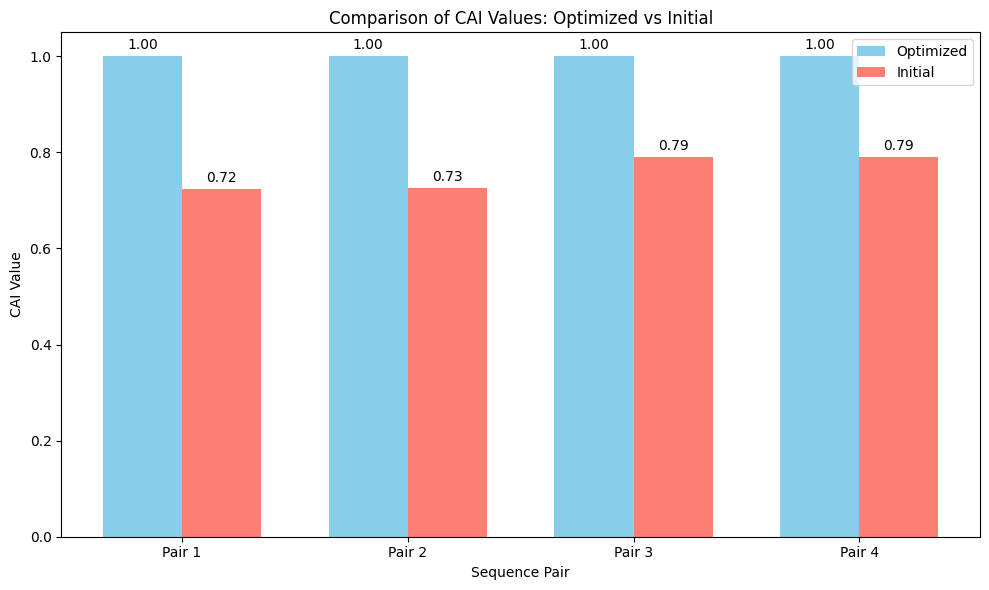

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fungsi untuk menghitung CAI_obs
def calculate_cai_obs(sequence, rscu_values):
    rscu_obs_values = []
    for codon in sequence:
        if codon in rscu_values:
            rscu_obs_values.append(rscu_values[codon])
        else:
            rscu_obs_values.append(0.5)
    cai_obs = np.prod(rscu_obs_values) ** (1 / len(rscu_obs_values))
    return cai_obs

# Fungsi untuk menghitung CAI_max
def calculate_cai_max(sequence, rscu_max_values):
    rscu_max_values_list = []
    for codon in sequence:
        if codon in rscu_max_values:
            rscu_max_values_list.append(rscu_max_values[codon])
        else:
            rscu_max_values_list.append(1.0)
    cai_max = np.prod(rscu_max_values_list) ** (1 / len(rscu_max_values_list))
    return cai_max

# Fungsi untuk menghitung CAI
def calculate_cai(sequence, rscu_values, rscu_max_values):
    cai_obs = calculate_cai_obs(sequence, rscu_values)
    cai_max = calculate_cai_max(sequence, rscu_max_values)
    cai = cai_obs / cai_max if cai_max != 0 else 0
    return cai

# Load data dari CSV untuk rscu_values dan rscu_max_values
rscu_df = pd.read_csv(rscu_df_path)
rscu_values = dict(zip(rscu_df['Codon'], rscu_df['RSCU']))
rscu_max_values = dict(zip(rscu_df['Codon'], rscu_df['RSCU_max']))

# Daftar variabel untuk CodonOptimized dan CodonInitial
Optimized = [CodonOptimized1, CodonOptimized2, CodonOptimized3, CodonOptimized4]
Initial = [CodonInitial1, CodonInitial2, CodonInitial3, CodonInitial4]

# Dictionary untuk menyimpan nilai CAI
cai_values = {}

# Loop untuk menghitung CAI setiap file pada CodonOptimized
for i, file_path in enumerate(Optimized, start=1):
    goi_df = pd.read_csv(file_path)
    sequence = goi_df['Codon'].tolist()
    cai_value = calculate_cai(sequence, rscu_values, rscu_max_values)
    cai_values[f"CodonOptimized{i}"] = cai_value

# Loop untuk menghitung CAI setiap file pada CodonInitial
for i, file_path in enumerate(Initial, start=1):
    goi_df = pd.read_csv(file_path)
    sequence = goi_df['Codon'].tolist()
    cai_value = calculate_cai(sequence, rscu_values, rscu_max_values)
    cai_values[f"CodonInitial{i}"] = cai_value

# Menyiapkan data untuk plotting
optimized_values = [cai_values[f"CodonOptimized{i}"] for i in range(1, 5)]
initial_values = [cai_values[f"CodonInitial{i}"] for i in range(1, 5)]
labels = [f"Pair {i}" for i in range(1, 5)]

# Plotting
x = np.arange(len(labels))
width = 0.35  # Lebar bar

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, optimized_values, width, label='Optimized', color='skyblue')
bars2 = ax.bar(x + width/2, initial_values, width, label='Initial', color='salmon')

# Menambahkan label, judul, dan keterangan
ax.set_xlabel('Sequence Pair')
ax.set_ylabel('CAI Value')
ax.set_title('Comparison of CAI Values: Optimized vs Initial')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Menambahkan nilai di atas setiap bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset posisi label
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()

# Simpan plot dalam format PDF di lokasi yang ditentukan
plt.savefig(save_path, format='pdf')

plt.show()


## Cek GC%

### Kami menyesuaikan adanya faktor GC% yang bisa ditoleransi pada tanaman chassis. Mengacu pada https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0212678, kami menggunakan data dari beberapa tanaman sebagai dasar data toleransi representatif untuk chassis yang digunakan.

 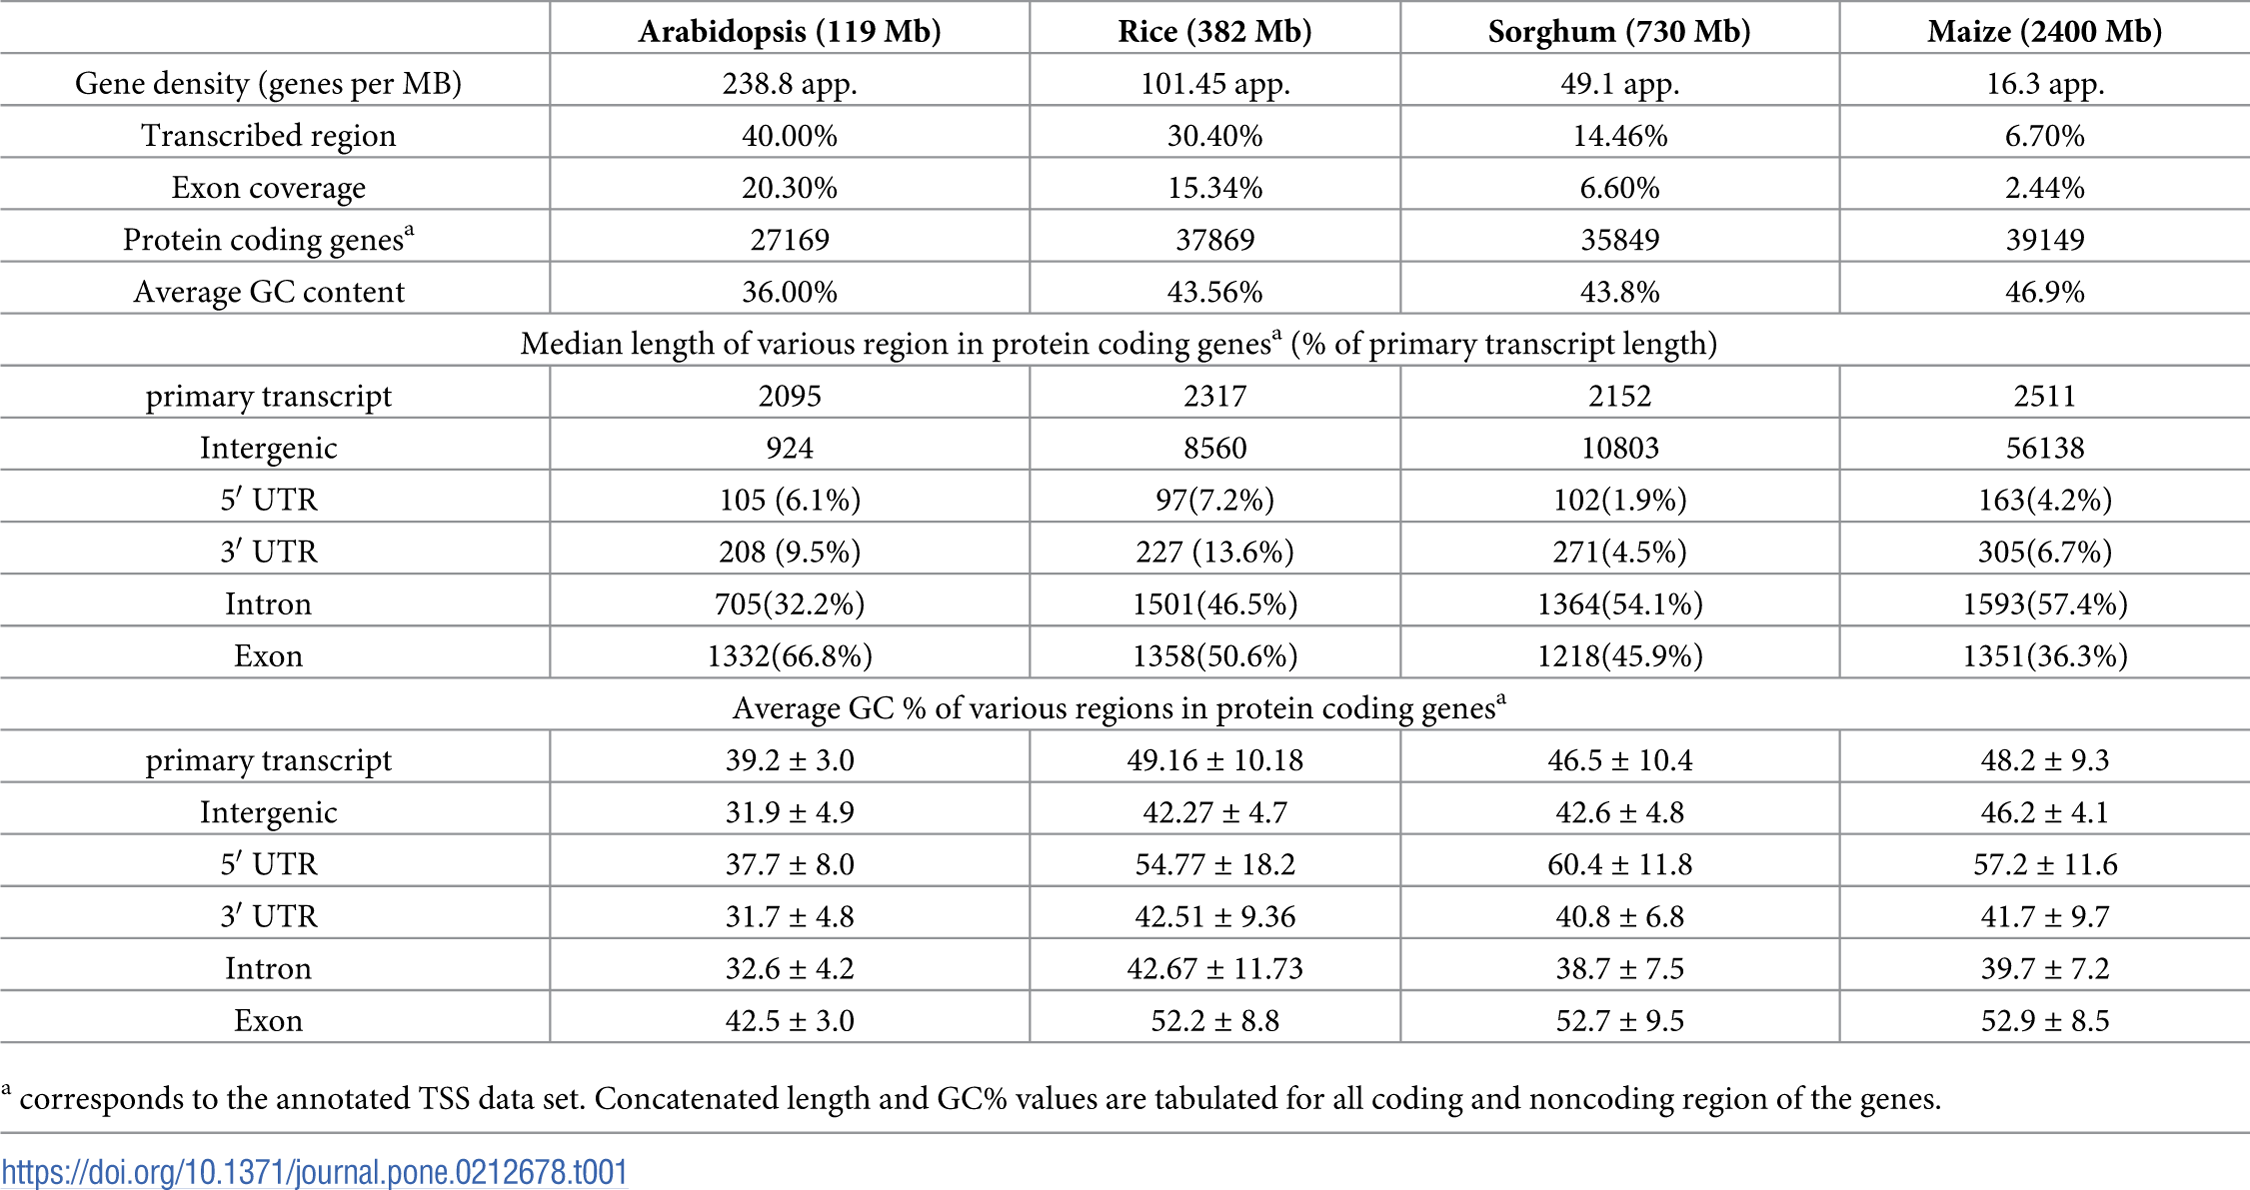

### Hitung GC% awal dari setiap sequence model

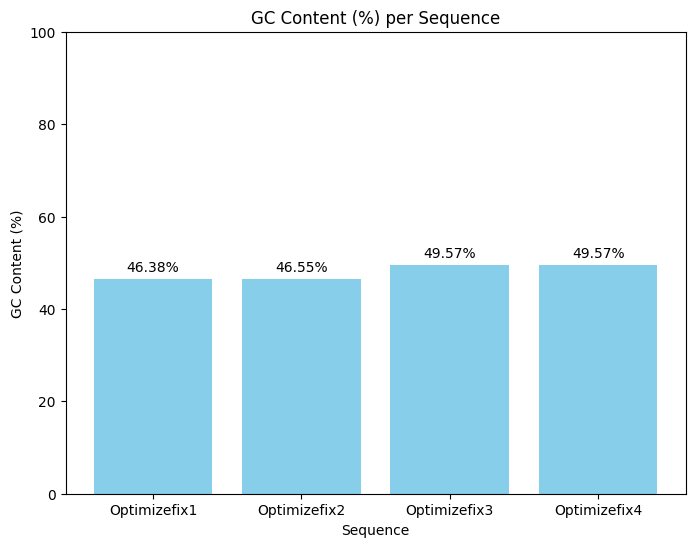

In [ ]:
from Bio import SeqIO
import matplotlib.pyplot as plt

# Fungsi untuk menghitung persentase GC
def gc_content(sequence):
    gc_count = sequence.count("G") + sequence.count("C")
    return (gc_count / len(sequence)) * 100 if len(sequence) > 0 else 0

# List path sequence (berformat fasta)
paths = [Optimizefix1, Optimizefix2, Optimizefix3, Optimizefix4]

# Menyimpan hasil GC%
gc_percentages = []

# Iterasi setiap file path dan hitung GC%
for path in paths:
    record = SeqIO.read(path, "fasta")
    gc_percent = gc_content(str(record.seq))
    gc_percentages.append(gc_percent)

# Plot GC% untuk setiap sequence
plt.figure(figsize=(8, 6))
bars = plt.bar([f"Optimizefix{i+1}" for i in range(4)], gc_percentages, color="skyblue")
plt.xlabel("Sequence")
plt.ylabel("GC Content (%)")
plt.title("GC Content (%) per Sequence")
plt.ylim(0, 100)  # Mengatur rentang y dari 0 hingga 100

# Menambahkan persentase di atas setiap bar
for bar, gc_percent in zip(bars, gc_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{gc_percent:.2f}%", ha='center', va='bottom')

plt.show()
